# Setup


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=2425b32a73921f1737d67874d41ef4ad05d36e3a07321a7e22a05caf75f5b5f8
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.nn import functional as F
import ta
import pandas as pd
import numpy as np


In [ ]:
filename = '/content/drive/MyDrive/stock_data.csv'
data: pd.DataFrame
try:
    data = pd.read_csv(filename)
except FileNotFoundError:
    print(f"Error: The file {filename} was not found. Please check the path.")


In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
def process_window(sample, input, target):
  for j in range(365):
    window = sample[j : j + 32]
    input = pd.concat([input, window], ignore_index=True)
    target = pd.concat([target, sample[j + 32 + 1:j + 64 + 1]], ignore_index=True)
  return input, target

sets = data.groupby('symbol')

input_df = pd.DataFrame()
target_df = pd.DataFrame()

with ThreadPoolExecutor() as ex:
  futures = {ex.submit(process_window, sets.get_group(i), input_df, target_df) for i in list(sets.groups.keys())[0:120]}


  for future in as_completed(futures):
    temp_in, temp_tar = future.result()
    input_df = pd.concat([input_df, temp_in], ignore_index=True)
    target_df = pd.concat([target_df, temp_tar], ignore_index=True)


"""for i in list(sets.groups.keys())[0:1]:
  test = sets.get_group(i)
  input_df, target_df = process_window(test, input_df, target_df)"""

display(input_df[-2:-1])
display(target_df[-2:-1])
display(target_df[-2:-1])

,Unnamed: 0,date,open,high,low,close,volume,symbol
1401598,394,2021-07-27,100.05,100.72,98.94,100.61,8332082,CVX


,Unnamed: 0,date,open,high,low,close,volume,symbol
1401598,427,2021-09-13,97.21,98.7099,97.06,97.97,11500862,CVX


,Unnamed: 0,date,open,high,low,close,volume,symbol
1401598,427,2021-09-13,97.21,98.7099,97.06,97.97,11500862,CVX


# Data Configuring


In [ ]:
def conv(tens):
  if tens > 0:
    return 0
  elif tens < 0:
    return 2
  else:
    return 1

In [ ]:
def make_dataset(input, target):
  input_df = pd.DataFrame()
  target_df = pd.DataFrame()

In [ ]:
data_range = 2**int(np.log2(len(input_df)))

in_data = input_df[:data_range]

targ_data = target_df[:data_range]
targ_data = (targ_data['close'] - targ_data['open']).apply(conv)

input_samp = input_df[:data_range]
targ_samp = target_df[:data_range]
targ_samp = (targ_samp['close'] - targ_samp['open']).apply(conv)

In [ ]:

feat = pd.DataFrame({
    "close": in_data['close'],
    "high": in_data['high'],
    "low": in_data['low'],
    "open": in_data['open'],
    "volume": in_data['volume'],
    "macd": ta.trend.macd(in_data['close'], fillna=True),
    "vwap": ta.volume.volume_weighted_average_price(in_data['high'], in_data['low'], in_data['close'], in_data['volume'], fillna=True),
    "rsi": ta.momentum.rsi(in_data['close'], fillna=True)
})



input_tensor = torch.tensor(feat.values, dtype=torch.float32)
input_tensor = F.normalize(input_tensor, dim=0)

target_tensor = torch.tensor(targ_data.values, dtype=torch.long)



In [ ]:
#input_tensor.view(2048, 32, -1).shape

In [ ]:
class StockDataset(torch.utils.data.Dataset):
    def __init__(self, input_tensor, target_tensor, seq=32):
        self.input_tensor = input_tensor.view(-1, seq, 8)
        self.target_tensor = target_tensor.view(-1, seq)
        self.seq = seq

    def __getitem__(self, index):
      return self.input_tensor[index, :, :], self.target_tensor[index, :]

    def __len__(self):
      return self.input_tensor.size(0)

In [ ]:
dataset = StockDataset(input_tensor, target_tensor, seq=32)
dataloader = DataLoader(dataset, batch_size=2048, shuffle=True, num_workers=0) # Set num_workers to 0

# LSTM Model

In [ ]:
class SPC(nn.Module):
    def __init__(self):
        super(SPC, self).__init__()
        self.rnn = nn.LSTM(8, 64, 2, batch_first=True)
        self.proj = nn.Linear(in_features=64, out_features=3)

    def forward(self, x):
      res, (hn, cn) = self.rnn(x)
      res = self.proj(res)
      return res

In [ ]:
model = SPC()
loss_data = []

# Training


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

opt = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

epoch = 10

for index in range(0, epoch):
  total_loss = 0
  for input, target in dataloader:
    input, target = input.to(device), target.to(device)
    opt.zero_grad()
    out = model(input)
    out = out.permute(0, 2, 1)
    loss = loss_fn(out, target)
    loss.backward()
    opt.step()
    total_loss = loss.item()
  print(f"Epoch {index + 1}: Loss = {total_loss}")
  loss_data.append(total_loss)

Using device: cuda
Epoch 1: Loss = 0.8922527432441711
Epoch 2: Loss = 0.7373557090759277
Epoch 3: Loss = 0.7279430031776428
Epoch 4: Loss = 0.7294818758964539
Epoch 5: Loss = 0.7260780930519104
Epoch 6: Loss = 0.7280541658401489
Epoch 7: Loss = 0.7241191267967224
Epoch 8: Loss = 0.7238698601722717
Epoch 9: Loss = 0.7213158011436462
Epoch 10: Loss = 0.7222580313682556


In [ ]:
torch.save(model.state_dict(), 'stock_prediction_model_weights.pth')
print("Model weights saved to 'stock_prediction_model_weights.pth'")

Model weights saved to 'stock_prediction_model_weights.pth'


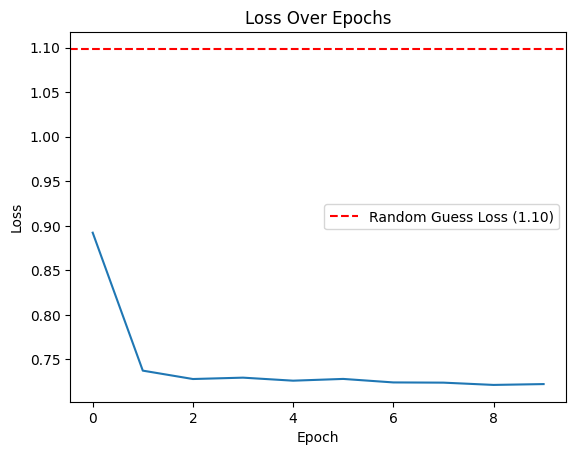

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the theoretical random guess loss for 3 classes
random_guess_loss = np.log(3)

plt.plot(loss_data)
plt.axhline(y=random_guess_loss, color='r', linestyle='--', label=f'Random Guess Loss ({random_guess_loss:.2f})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
torch.argmax(model(input),dim=2)[0]

tensor([2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')